This is an old version of the optuna hyperparemeter optimization for iterative ptychography. I wouldn't expect it to actually work still, but leaving it as a placeholder. 

Idea is that this notebook will include Optuna based hyperparameter optimization or similar.

Stephanie Ribet and Arthur McCray



In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import importlib
from pathlib import Path

# import matplotlib.pyplot as plt
import numpy as np
import torch

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.core.visualization import show_2d
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
from quantem.diffractive_imaging.detector_models import DetectorPixelated
from quantem.diffractive_imaging.object_models import ObjectDIP, ObjectPixelated
from quantem.diffractive_imaging.probe_models import ProbePixelated
from quantem.diffractive_imaging.ptychography import Ptychography
import matplotlib.pyplot as plt

config.set_device(1)
print(config.get("device"))


/home/amccray/code/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1


In [3]:
# data_dir = Path("~/quantem-tutorials/data/").expanduser()
# file_data = data_dir / "ducky_clean.zip"
file_data = Path("~/code/quantem-tutorials/data/ducky_clean.zip").expanduser()
dset: Dataset4dstem = em.io.load(file_data)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

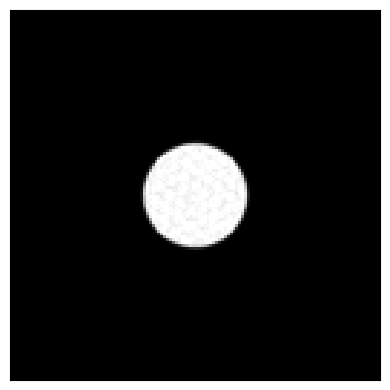

In [4]:
show_2d(dset[0,0].array)

Calculated best fit rotation = 0 degrees.


Normalizing intensities: 100%|██████████| 625/625 [00:00<00:00, 1325.03probe position/s]


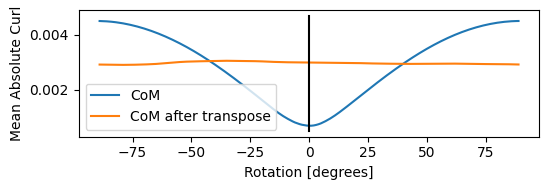

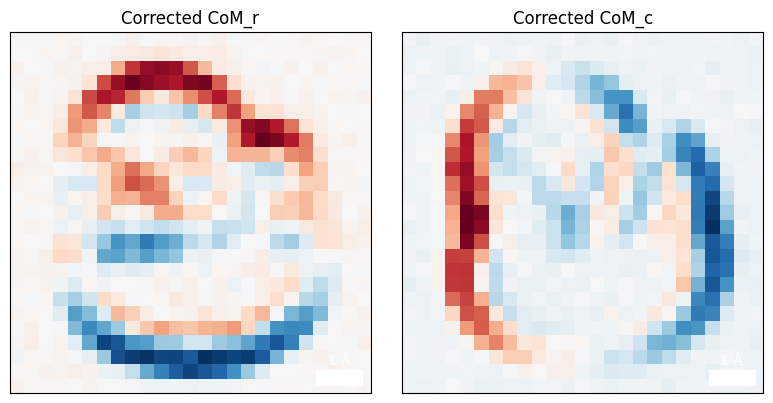

In [5]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)

pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=True,
    plot_com=True,
)

## pixelated

In [55]:
from quantem.diffractive_imaging.logger_ptychography import LoggerPtychography
# logger = LoggerPtychography(
#     # log_dir = "../logs/",
#     log_dir = data_dir / "logs",
#     run_prefix=dset.name,
#     run_suffix="",
#     log_images_every=10,
#     log_probe_images=False,
# )

obj_model = ObjectPixelated.from_uniform(
    num_slices=1,
    slice_thicknesses=10,
    obj_type="pure_phase",
)

probe_params = {
    "energy": 80e3, # TRUE is 80e3
    "defocus": 470, # TRUE is 500
    "semiangle_cutoff": 20, # TRUE is 20
}

# probe_model = ProbePixelated(
#     num_probes=1,
#     probe_params=probe_params,
# )

probe_model = ProbePixelated.from_params(
    num_probes=1,
    probe_params=probe_params,
)
# probe_model = ProbePixelated.from_array(
#     num_probes=1,
#     probe_array=pa,
# )

detector_model = DetectorPixelated()


ptycho = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model,
    probe_model=probe_model,
    detector_model=detector_model,
    # logger=logger,
    rng=42, 
)

ptycho.preprocess(
    obj_padding_px=(32, 32),
)

Epoch 500/500, Loss: 1.385e+00: 100%|██████████| 500/500 [00:19<00:00, 25.94it/s]


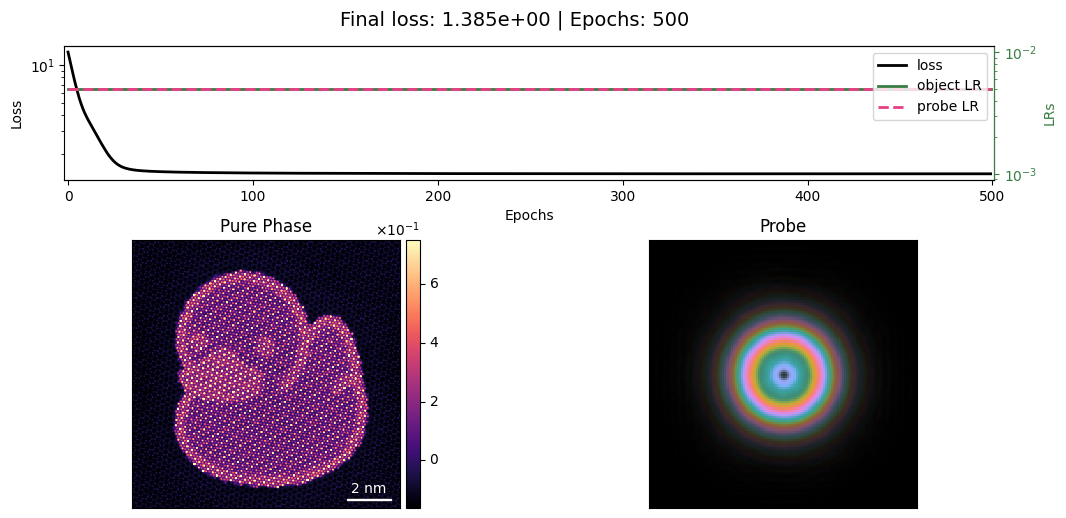

In [58]:
# this vs having a single lr for all params from dataset (currently just scan positions and descan)
opt_params = {  # except type, all args are passed to the optimizer (of type type)
    "object": {
        "type": "adam",
        "lr": 5e-3,
        # "type": "sgd",
        # "lr": 0.5,
    },
    "probe": {
        "type": "adam",
        "lr": 5e-3,
        # "type": "sgd",
        # "lr": 0.5,
    },
    # "dataset": {
    #     "type": "adam",
    #     "lr": 1e-2,
    # }
}

scheduler_params = {
    # "object": {
    #     "type": "exp",
    #     "factor": 0.1,
    #     # "type": "plateau",
    #     # "patience": 100,
    #     # "threshold": 1e-2,
    #     # "cooldown": 100,
    # },
    # "probe": {
    #     "type": "exp",
    #     "factor": 0.5,
    #     # "type": "plateau",
    #     # "threshold": 1e-2,
    #     # "patience": 100,
    #     # "cooldown": 100,
    # }
    # # "dataset" - cover descan and scan positions
}

constraints = {
    # "object": {
    #     "tv_weight_yx": 0.,  # 0.0001,
    #     "tv_weight_z": 0,
    #     "fix_potential_baseline": True,
    #     "identical_slices": True,
    # },
    # "probe": {
    #     "center_probe": False,
    #     "tv_weight": 0.,
    # },
    # # "dataset":{
    # #     "descan_tv_weight": 0,
    # #     # "descan_shifts_constant": False,
    # # }
}


ptycho.reconstruct(
    num_iter=500,
    reset=True,
    autograd=True,
    device="gpu",
    constraints=constraints,
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    batch_size=125,
).visualize()    


(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'pixelated pure_phase | 500 epochs'}>,
        <Axes: title={'center': 'zoom'}>, <Axes: title={'center': 'zoom'}>],
       dtype=object))

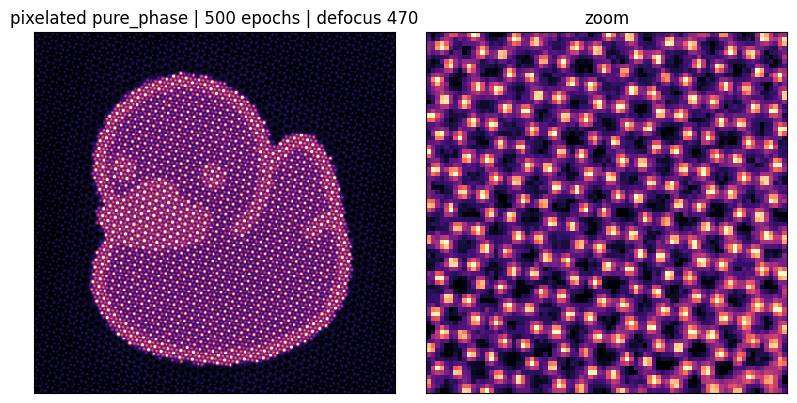

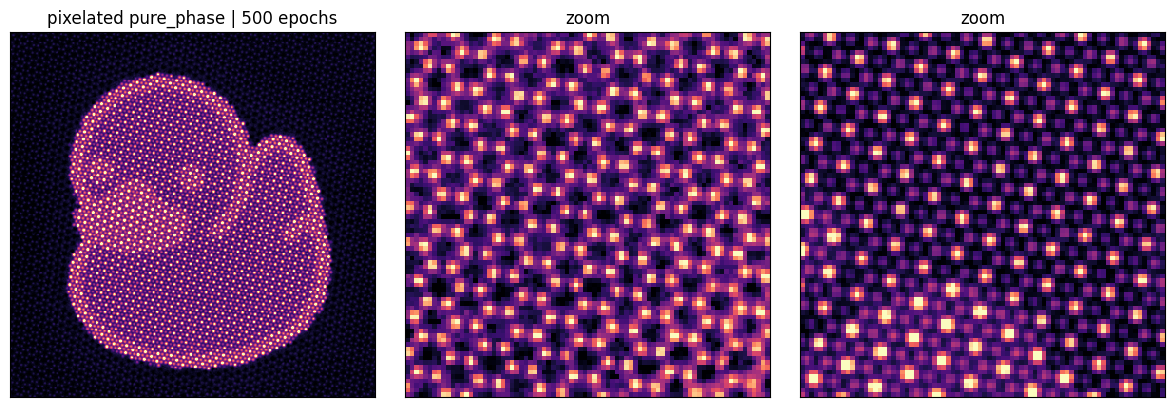

In [59]:
show_2d(
    [np.angle(ptycho.obj_cropped[0]), np.angle(ptycho.obj_cropped[0, :80, :80])],
    cmap=["magma", "magma"],
    title = [
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs | defocus {ptycho.probe_model.probe_params['defocus']}",
        f"zoom",
    ]
)
show_2d(
    [
        np.angle(ptycho.obj_cropped[0]),
        np.angle(ptycho.obj_cropped[0, :80, :80]),
        np.angle(ptycho.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        f"zoom",
        f"zoom",
    ],
)

In [23]:
# New optimizer utilities (embedded parameters + runner with tqdm)
from quantem.diffractive_imaging.optimize import (
    OptimizationParameter,
    OptimizeIterativePtychography,
)

# 1) Map component constructors
constructors = {
    "object": ObjectPixelated.from_uniform,
    "probe": ProbePixelated.from_params,
    "detector": DetectorPixelated,
    "ptycho": Ptychography.from_models,
}

NUM_SLICES = 1
NUM_PROBES = 1
PROBE_ENERGY = 80e3
PROBE_SEMIANGLE = 20
PROBE_DEFOCUS = 500

# 2) Embed OptimizationParameter directly in the kwargs where you want sampling
base_kwargs = {
    "object": {
        "num_slices": NUM_SLICES,
        "obj_type": "potential",
    },
    "probe": {
        "num_probes": NUM_PROBES,
        "probe_params": {
            "energy": PROBE_ENERGY,
            "semiangle_cutoff": PROBE_SEMIANGLE,
            # This will be sampled each trial by Optuna
            "defocus": OptimizationParameter(low=300, high=700),
        },
    },
    "detector": {
        # add detector kwargs if needed
    },
    "ptycho": {
        "dset": pdset,
        "device": "cpu",
        "verbose": False,
    },
    "preprocess": {
        "batch_size": 128,
        # add other preprocess kwargs if needed
    },
    "reconstruct": {
        "num_iter": 10,
        "reset": True,
        "autograd": True,
        "device": "gpu",
        "constraints": constraints,
        "optimizer_params": opt_params,
        "scheduler_params": scheduler_params,
        "batch_size": 128,
    },
}

    # 4) Run optimization with embedded tqdm progress bar
study = OptimizeIterativePtychography(
    constructors=constructors,
    base_kwargs=base_kwargs,
    n_trials=20,
)

[I 2025-09-04 01:05:47,009] A new study created in memory with name: no-name-8a4111f3-1c89-423b-8fd6-e3863f06057e
optimizing:   0%|          | 0/20 [00:00<?, ?trial/s]

[I 2025-09-04 01:05:47,306] Trial 0 finished with value: 6.3098978996276855 and parameters: {'probe.probe_params.defocus': 322}. Best is trial 0 with value: 6.3098978996276855.
optimizing: 100%|██████████| 20/20 [00:05<00:00,  3.72trial/s]


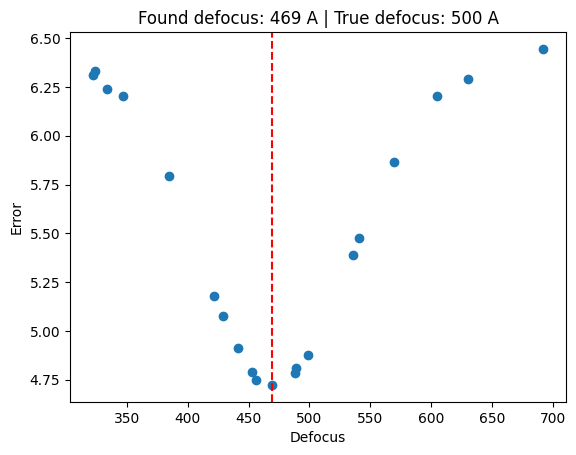

In [24]:
data = study.get_trials()
defocus_values = np.array([trial.params["probe.probe_params.defocus"] for trial in data])
errors = np.array([trial.values[0] for trial in data])

found_defocus = defocus_values[np.argmin(errors)]

fig, ax = plt.subplots()
ax.scatter(defocus_values,errors)
ax.axvline(found_defocus, color="red", linestyle="--")
ax.set_title(f"Found defocus: {found_defocus:.0f} A | True defocus: 500 A")
ax.set_xlabel("Defocus")
ax.set_ylabel("Error")

plt.show()

In [33]:
plt.close('all')

In [43]:
# New optimizer utilities (embedded parameters + runner with tqdm)
from quantem.diffractive_imaging.optimize import (
    OptimizationParameter,
    OptimizeIterativePtychography,
)

# 1) Map component constructors
constructors = {
    "object": ObjectPixelated.from_uniform,
    "probe": ProbePixelated.from_params,
    "detector": DetectorPixelated,
    "ptycho": Ptychography.from_models,
}

NUM_SLICES = 1
NUM_PROBES = 1
PROBE_ENERGY = 80e3
PROBE_SEMIANGLE = 20
PROBE_DEFOCUS = 500

# 2) Embed OptimizationParameter directly in the kwargs where you want sampling
base_kwargs = {
    "object": {
        "num_slices": NUM_SLICES,
        "obj_type": "potential",
    },
    "probe": {
        "num_probes": NUM_PROBES,
        "probe_params": {
            "energy": PROBE_ENERGY,
            "semiangle_cutoff": OptimizationParameter(low=10, high=30),
            # This will be sampled each trial by Optuna
            "defocus": OptimizationParameter(low=300, high=700),
        },
    },
    "detector": {
        # add detector kwargs if needed
    },
    "ptycho": {
        "dset": pdset,
        "device": "cpu",
        "verbose": False,
    },
    "preprocess": {
        "batch_size": 128,
        # add other preprocess kwargs if needed
    },
    "reconstruct": {
        "num_iter": 20,
        "reset": True,
        "autograd": True,
        "device": "gpu",
        "constraints": constraints,
        "optimizer_params": opt_params,
        "scheduler_params": scheduler_params,
        "batch_size": 128,
    },
}

    # 4) Run optimization with embedded tqdm progress bar
study = OptimizeIterativePtychography(
    constructors=constructors,
    base_kwargs=base_kwargs,
    n_trials=50,
)

[I 2025-09-02 15:34:34,182] A new study created in memory with name: no-name-26518fc2-124d-40b4-8618-f9f47ceb8cc9
optimizing:   2%|▏         | 1/50 [00:00<00:29,  1.65trial/s]

[I 2025-09-02 15:34:34,788] Trial 0 finished with value: 5.296409702301025 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 616}. Best is trial 0 with value: 5.296409702301025.



optimizing:   4%|▍         | 2/50 [00:01<00:33,  1.44trial/s]                     

[I 2025-09-02 15:34:35,541] Trial 1 finished with value: 95.93804473876953 and parameters: {'probe.probe_params.semiangle_cutoff': 23, 'probe.probe_params.defocus': 447}. Best is trial 0 with value: 5.296409702301025.



optimizing:   6%|▌         | 3/50 [00:01<00:30,  1.52trial/s]                     

[I 2025-09-02 15:34:36,153] Trial 2 finished with value: 287.10736083984375 and parameters: {'probe.probe_params.semiangle_cutoff': 29, 'probe.probe_params.defocus': 659}. Best is trial 0 with value: 5.296409702301025.



optimizing:   8%|▊         | 4/50 [00:02<00:29,  1.55trial/s]                     

[I 2025-09-02 15:34:36,779] Trial 3 finished with value: 286.6795166015625 and parameters: {'probe.probe_params.semiangle_cutoff': 29, 'probe.probe_params.defocus': 611}. Best is trial 0 with value: 5.296409702301025.



optimizing:  10%|█         | 5/50 [00:03<00:28,  1.57trial/s]                     

[I 2025-09-02 15:34:37,403] Trial 4 finished with value: 202.8930694580078 and parameters: {'probe.probe_params.semiangle_cutoff': 26, 'probe.probe_params.defocus': 689}. Best is trial 0 with value: 5.296409702301025.



optimizing:  12%|█▏        | 6/50 [00:03<00:27,  1.58trial/s]                     

[I 2025-09-02 15:34:38,029] Trial 5 finished with value: 96.37087554931641 and parameters: {'probe.probe_params.semiangle_cutoff': 23, 'probe.probe_params.defocus': 312}. Best is trial 0 with value: 5.296409702301025.



optimizing:  14%|█▍        | 7/50 [00:04<00:27,  1.58trial/s]                     

[I 2025-09-02 15:34:38,665] Trial 6 finished with value: 235.61705017089844 and parameters: {'probe.probe_params.semiangle_cutoff': 27, 'probe.probe_params.defocus': 567}. Best is trial 0 with value: 5.296409702301025.



optimizing:  16%|█▌        | 8/50 [00:05<00:26,  1.60trial/s]                     

[I 2025-09-02 15:34:39,275] Trial 7 finished with value: 18.15541801452637 and parameters: {'probe.probe_params.semiangle_cutoff': 21, 'probe.probe_params.defocus': 536}. Best is trial 0 with value: 5.296409702301025.



optimizing:  18%|█▊        | 9/50 [00:05<00:25,  1.60trial/s]                     

[I 2025-09-02 15:34:39,900] Trial 8 finished with value: 292.8939636230469 and parameters: {'probe.probe_params.semiangle_cutoff': 13, 'probe.probe_params.defocus': 424}. Best is trial 0 with value: 5.296409702301025.



optimizing:  20%|██        | 10/50 [00:06<00:25,  1.58trial/s]                    

[I 2025-09-02 15:34:40,548] Trial 9 finished with value: 232.97777099609374 and parameters: {'probe.probe_params.semiangle_cutoff': 27, 'probe.probe_params.defocus': 643}. Best is trial 0 with value: 5.296409702301025.



optimizing:  22%|██▏       | 11/50 [00:07<00:24,  1.56trial/s]                     

[I 2025-09-02 15:34:41,202] Trial 10 finished with value: 156.8037139892578 and parameters: {'probe.probe_params.semiangle_cutoff': 16, 'probe.probe_params.defocus': 471}. Best is trial 0 with value: 5.296409702301025.



optimizing:  24%|██▍       | 12/50 [00:08<00:36,  1.05trial/s]                     

[I 2025-09-02 15:34:42,876] Trial 11 finished with value: 70.10013885498047 and parameters: {'probe.probe_params.semiangle_cutoff': 18, 'probe.probe_params.defocus': 552}. Best is trial 0 with value: 5.296409702301025.



optimizing:  26%|██▌       | 13/50 [00:09<00:31,  1.17trial/s]                     

[I 2025-09-02 15:34:43,500] Trial 12 finished with value: 18.23087158203125 and parameters: {'probe.probe_params.semiangle_cutoff': 21, 'probe.probe_params.defocus': 538}. Best is trial 0 with value: 5.296409702301025.



optimizing:  28%|██▊       | 14/50 [00:09<00:28,  1.28trial/s]                     

[I 2025-09-02 15:34:44,115] Trial 13 finished with value: 439.91318969726564 and parameters: {'probe.probe_params.semiangle_cutoff': 10, 'probe.probe_params.defocus': 379}. Best is trial 0 with value: 5.296409702301025.



optimizing:  30%|███       | 15/50 [00:10<00:25,  1.37trial/s]                     

[I 2025-09-02 15:34:44,733] Trial 14 finished with value: 25.760898208618165 and parameters: {'probe.probe_params.semiangle_cutoff': 19, 'probe.probe_params.defocus': 604}. Best is trial 0 with value: 5.296409702301025.



optimizing:  32%|███▏      | 16/50 [00:11<00:24,  1.38trial/s]                     

[I 2025-09-02 15:34:45,434] Trial 15 finished with value: 206.32366027832032 and parameters: {'probe.probe_params.semiangle_cutoff': 15, 'probe.probe_params.defocus': 510}. Best is trial 0 with value: 5.296409702301025.



optimizing:  34%|███▍      | 17/50 [00:11<00:23,  1.43trial/s]                     

[I 2025-09-02 15:34:46,083] Trial 16 finished with value: 54.48038330078125 and parameters: {'probe.probe_params.semiangle_cutoff': 22, 'probe.probe_params.defocus': 589}. Best is trial 0 with value: 5.296409702301025.



optimizing:  36%|███▌      | 18/50 [00:12<00:21,  1.47trial/s]                     

[I 2025-09-02 15:34:46,712] Trial 17 finished with value: 68.50890808105468 and parameters: {'probe.probe_params.semiangle_cutoff': 18, 'probe.probe_params.defocus': 502}. Best is trial 0 with value: 5.296409702301025.



optimizing:  38%|███▊      | 19/50 [00:13<00:20,  1.51trial/s]                     

[I 2025-09-02 15:34:47,338] Trial 18 finished with value: 169.9934509277344 and parameters: {'probe.probe_params.semiangle_cutoff': 25, 'probe.probe_params.defocus': 638}. Best is trial 0 with value: 5.296409702301025.



optimizing:  40%|████      | 20/50 [00:13<00:19,  1.53trial/s]                     

[I 2025-09-02 15:34:47,965] Trial 19 finished with value: 4.369339799880981 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 390}. Best is trial 19 with value: 4.369339799880981.



optimizing:  42%|████▏     | 21/50 [00:14<00:18,  1.56trial/s]                      

[I 2025-09-02 15:34:48,583] Trial 20 finished with value: 205.52933654785156 and parameters: {'probe.probe_params.semiangle_cutoff': 15, 'probe.probe_params.defocus': 353}. Best is trial 19 with value: 4.369339799880981.



optimizing:  44%|████▍     | 22/50 [00:15<00:17,  1.57trial/s]                      

[I 2025-09-02 15:34:49,210] Trial 21 finished with value: 3.8033135890960694 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 416}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  46%|████▌     | 23/50 [00:15<00:17,  1.59trial/s]                      

[I 2025-09-02 15:34:49,823] Trial 22 finished with value: 4.128660058975219 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 401}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  48%|████▊     | 24/50 [00:16<00:16,  1.59trial/s]                      

[I 2025-09-02 15:34:50,451] Trial 23 finished with value: 116.51798095703126 and parameters: {'probe.probe_params.semiangle_cutoff': 17, 'probe.probe_params.defocus': 402}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  50%|█████     | 25/50 [00:16<00:15,  1.58trial/s]                      

[I 2025-09-02 15:34:51,091] Trial 24 finished with value: 135.4930908203125 and parameters: {'probe.probe_params.semiangle_cutoff': 24, 'probe.probe_params.defocus': 339}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  52%|█████▏    | 26/50 [00:17<00:15,  1.54trial/s]                      

[I 2025-09-02 15:34:51,773] Trial 25 finished with value: 4.510465240478515 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 384}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  54%|█████▍    | 27/50 [00:18<00:15,  1.48trial/s]                      

[I 2025-09-02 15:34:52,519] Trial 26 finished with value: 285.70009155273436 and parameters: {'probe.probe_params.semiangle_cutoff': 13, 'probe.probe_params.defocus': 446}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  56%|█████▌    | 28/50 [00:18<00:14,  1.49trial/s]                      

[I 2025-09-02 15:34:53,170] Trial 27 finished with value: 53.72606353759765 and parameters: {'probe.probe_params.semiangle_cutoff': 22, 'probe.probe_params.defocus': 304}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  58%|█████▊    | 29/50 [00:19<00:13,  1.52trial/s]                      

[I 2025-09-02 15:34:53,803] Trial 28 finished with value: 25.07678680419922 and parameters: {'probe.probe_params.semiangle_cutoff': 19, 'probe.probe_params.defocus': 416}. Best is trial 21 with value: 3.8033135890960694.



optimizing:  60%|██████    | 30/50 [00:20<00:13,  1.53trial/s]                      

[I 2025-09-02 15:34:54,451] Trial 29 finished with value: 3.0054416179656984 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 469}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  62%|██████▏   | 31/50 [00:20<00:12,  1.55trial/s]                      

[I 2025-09-02 15:34:55,076] Trial 30 finished with value: 117.82279205322266 and parameters: {'probe.probe_params.semiangle_cutoff': 17, 'probe.probe_params.defocus': 449}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  64%|██████▍   | 32/50 [00:21<00:11,  1.55trial/s]                      

[I 2025-09-02 15:34:55,722] Trial 31 finished with value: 3.045750856399536 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 476}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  66%|██████▌   | 33/50 [00:22<00:10,  1.57trial/s]                      

[I 2025-09-02 15:34:56,340] Trial 32 finished with value: 17.001676177978517 and parameters: {'probe.probe_params.semiangle_cutoff': 21, 'probe.probe_params.defocus': 482}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  68%|██████▊   | 34/50 [00:22<00:10,  1.58trial/s]                      

[I 2025-09-02 15:34:56,966] Trial 33 finished with value: 96.14820861816406 and parameters: {'probe.probe_params.semiangle_cutoff': 23, 'probe.probe_params.defocus': 470}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  70%|███████   | 35/50 [00:23<00:09,  1.50trial/s]                      

[I 2025-09-02 15:34:57,703] Trial 34 finished with value: 24.94837417602539 and parameters: {'probe.probe_params.semiangle_cutoff': 19, 'probe.probe_params.defocus': 443}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  72%|███████▏  | 36/50 [00:24<00:09,  1.52trial/s]                      

[I 2025-09-02 15:34:58,340] Trial 35 finished with value: 3.560479736328125 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 427}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  74%|███████▍  | 37/50 [00:24<00:08,  1.54trial/s]                      

[I 2025-09-02 15:34:58,977] Trial 36 finished with value: 138.33407592773438 and parameters: {'probe.probe_params.semiangle_cutoff': 24, 'probe.probe_params.defocus': 485}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  76%|███████▌  | 38/50 [00:25<00:07,  1.56trial/s]                      

[I 2025-09-02 15:34:59,595] Trial 37 finished with value: 57.06635055541992 and parameters: {'probe.probe_params.semiangle_cutoff': 22, 'probe.probe_params.defocus': 515}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  78%|███████▊  | 39/50 [00:26<00:07,  1.47trial/s]                      

[I 2025-09-02 15:35:00,372] Trial 38 finished with value: 70.17288208007812 and parameters: {'probe.probe_params.semiangle_cutoff': 18, 'probe.probe_params.defocus': 362}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  80%|████████  | 40/50 [00:26<00:06,  1.52trial/s]                      

[I 2025-09-02 15:35:00,974] Trial 39 finished with value: 117.22476806640626 and parameters: {'probe.probe_params.semiangle_cutoff': 17, 'probe.probe_params.defocus': 431}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  82%|████████▏ | 41/50 [00:27<00:05,  1.52trial/s]                      

[I 2025-09-02 15:35:01,628] Trial 40 finished with value: 96.12651672363282 and parameters: {'probe.probe_params.semiangle_cutoff': 23, 'probe.probe_params.defocus': 470}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  84%|████████▍ | 42/50 [00:28<00:05,  1.55trial/s]                      

[I 2025-09-02 15:35:02,252] Trial 41 finished with value: 3.9681911945343016 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 408}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  86%|████████▌ | 43/50 [00:28<00:04,  1.54trial/s]                      

[I 2025-09-02 15:35:02,905] Trial 42 finished with value: 17.505971145629882 and parameters: {'probe.probe_params.semiangle_cutoff': 21, 'probe.probe_params.defocus': 416}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  88%|████████▊ | 44/50 [00:29<00:03,  1.51trial/s]                      

[I 2025-09-02 15:35:03,594] Trial 43 finished with value: 3.069901371002197 and parameters: {'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 457}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  90%|█████████ | 45/50 [00:30<00:03,  1.49trial/s]                      

[I 2025-09-02 15:35:04,286] Trial 44 finished with value: 314.12518310546875 and parameters: {'probe.probe_params.semiangle_cutoff': 30, 'probe.probe_params.defocus': 455}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  92%|█████████▏| 46/50 [00:30<00:02,  1.48trial/s]                      

[I 2025-09-02 15:35:04,974] Trial 45 finished with value: 24.874906158447267 and parameters: {'probe.probe_params.semiangle_cutoff': 19, 'probe.probe_params.defocus': 436}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  94%|█████████▍| 47/50 [00:31<00:02,  1.46trial/s]                      

[I 2025-09-02 15:35:05,687] Trial 46 finished with value: 161.52633972167968 and parameters: {'probe.probe_params.semiangle_cutoff': 16, 'probe.probe_params.defocus': 528}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  96%|█████████▌| 48/50 [00:32<00:01,  1.48trial/s]                      

[I 2025-09-02 15:35:06,337] Trial 47 finished with value: 55.75606002807617 and parameters: {'probe.probe_params.semiangle_cutoff': 22, 'probe.probe_params.defocus': 485}. Best is trial 29 with value: 3.0054416179656984.



optimizing:  98%|█████████▊| 49/50 [00:32<00:00,  1.52trial/s]                      

[I 2025-09-02 15:35:06,961] Trial 48 finished with value: 69.7826171875 and parameters: {'probe.probe_params.semiangle_cutoff': 18, 'probe.probe_params.defocus': 462}. Best is trial 29 with value: 3.0054416179656984.



optimizing: 100%|██████████| 50/50 [00:33<00:00,  1.50trial/s]

[I 2025-09-02 15:35:07,594] Trial 49 finished with value: 18.602996826171875 and parameters: {'probe.probe_params.semiangle_cutoff': 21, 'probe.probe_params.defocus': 563}. Best is trial 29 with value: 3.0054416179656984.


In [47]:
data

[FrozenTrial(number=0, state=1, values=[5.296409702301025], datetime_start=datetime.datetime(2025, 9, 2, 15, 34, 34, 185326), datetime_complete=datetime.datetime(2025, 9, 2, 15, 34, 34, 788575), params={'probe.probe_params.semiangle_cutoff': 20, 'probe.probe_params.defocus': 616}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'probe.probe_params.semiangle_cutoff': IntDistribution(high=30, log=False, low=10, step=1), 'probe.probe_params.defocus': IntDistribution(high=700, log=False, low=300, step=1)}, trial_id=0, value=None),
 FrozenTrial(number=1, state=1, values=[95.93804473876953], datetime_start=datetime.datetime(2025, 9, 2, 15, 34, 34, 793323), datetime_complete=datetime.datetime(2025, 9, 2, 15, 34, 35, 541648), params={'probe.probe_params.semiangle_cutoff': 23, 'probe.probe_params.defocus': 447}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'probe.probe_params.semiangle_cutoff': IntDistribution(high=30, log=False, low=10, step=1),

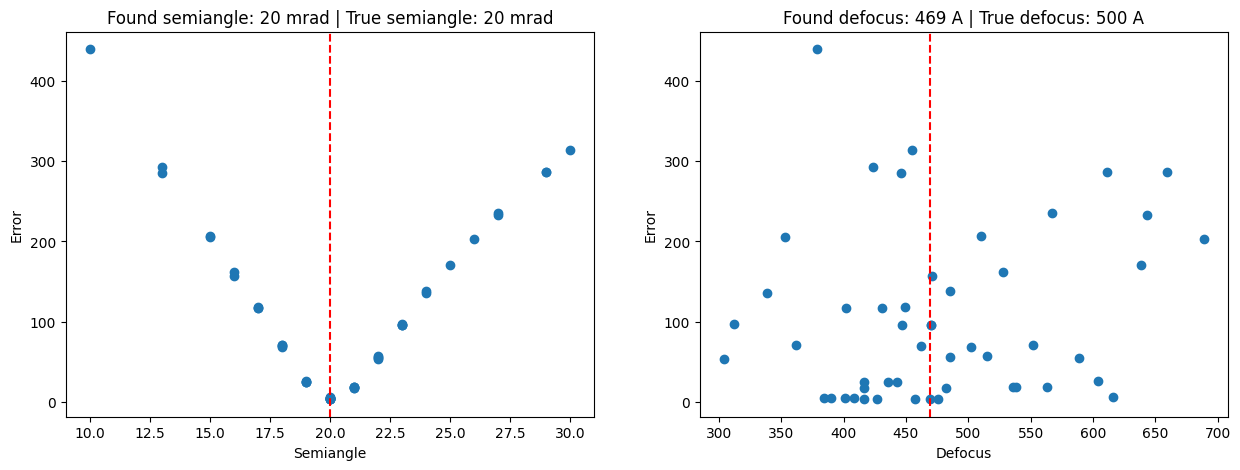

In [54]:
data = study.get_trials()
defocus_values = np.array([trial.params["probe.probe_params.defocus"] for trial in data])
semiangle_values = np.array([trial.params["probe.probe_params.semiangle_cutoff"] for trial in data])
errors = np.array([trial.values[0] for trial in data])

found_defocus = defocus_values[np.argmin(errors)]
found_semiangle = semiangle_values[np.argmin(errors)]

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].scatter(semiangle_values,errors)
ax[0].axvline(found_semiangle, color="red", linestyle="--")
ax[0].set_title(f"Found semiangle: {found_semiangle:.0f} mrad | True semiangle: 20 mrad")
ax[0].set_xlabel("Semiangle")
ax[0].set_ylabel("Error")

ax[1].scatter(defocus_values,errors)
ax[1].axvline(found_defocus, color="red", linestyle="--")
ax[1].set_title(f"Found defocus: {found_defocus:.0f} A | True defocus: 500 A")
ax[1].set_xlabel("Defocus")
ax[1].set_ylabel("Error")
# ax[1].set_ylim(0, 10) 

plt.show()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'pixelated pure_phase | 50 epochs'}>,
        <Axes: title={'center': 'zoom'}>, <Axes: title={'center': 'zoom'}>],
       dtype=object))

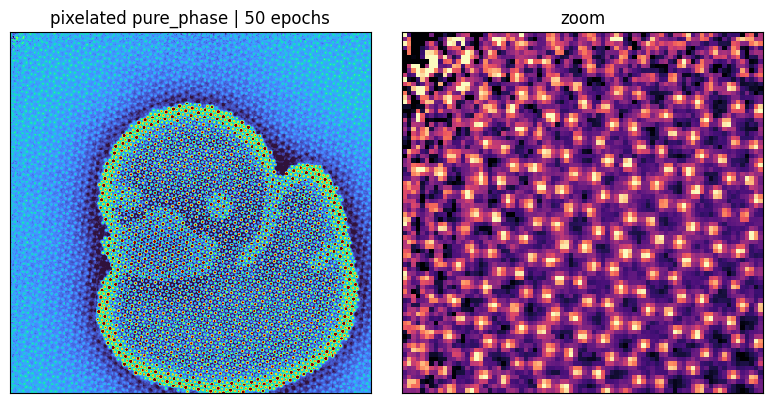

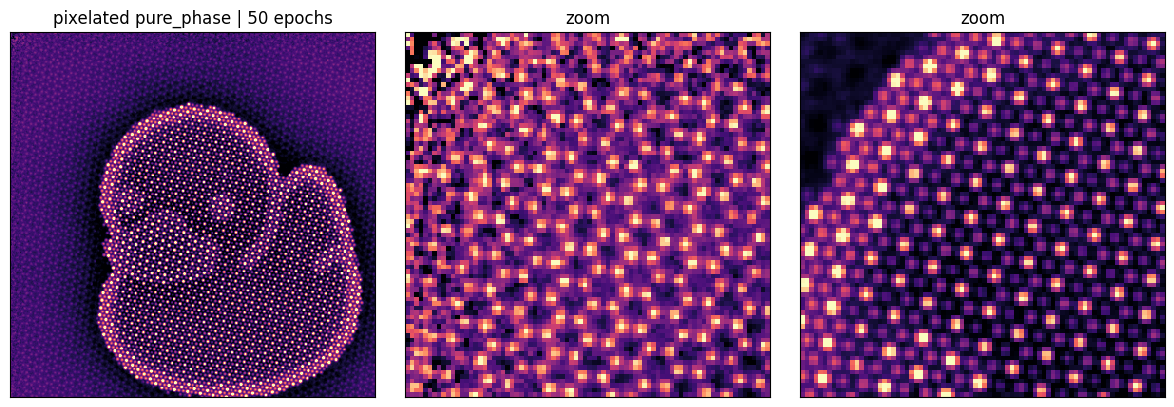

In [11]:
show_2d(
    [np.angle(ptycho.obj_cropped[0]), np.angle(ptycho.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title = [
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        f"zoom",
    ]
)
show_2d(
    [
        np.angle(ptycho.obj_cropped[0]),
        np.angle(ptycho.obj_cropped[0, :80, :80]),
        np.angle(ptycho.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[
        f"pixelated {ptycho.obj_model.obj_type} | {ptycho.num_epochs} epochs",
        f"zoom",
        f"zoom",
    ],
)

## DIP

In [ ]:
from quantem.core.ml.cnn2d import CNN2d
from quantem.diffractive_imaging.probe_models import ProbeDIP

model_dip = CNN2d(
    in_channels=1,
    start_filters=32,
    num_layers=3,
    use_skip_connections=True,
    dtype=torch.float32,
    # dtype = torch.complex64,
    use_batchnorm=True,
    # final_activation="relu",
)

obj_model_dip = ObjectDIP.from_model(
    model=model_dip,
    # model_input=ptycho.obj_model.obj.angle(), #ptycho.obj_model.obj, # ptycho.obj_model.obj.angle() - ptycho.obj_model.obj.angle().min(),
    shape=ptycho.obj_model.shape,
    num_slices=1,
    slice_thicknesses=10,
    obj_type="pure_phase",
    device=config.get("device"),
    rng=42,
    input_noise_std=0.025,
)

probe_dip = CNN2d(
    in_channels=1,
    start_filters=32,
    num_layers=3,
    use_skip_connections=True,
    dtype = torch.complex64,
    use_batchnorm=True,
)

# probe_model_dip = ProbeDIP(
#     model=probe_dip,
#     # model_input=ptycho.probe_model.probe,
#     roi_shape=ptycho.probe_model.roi_shape,
#     num_probes=1,
#     device=config.get("device"),
# )

probe_model_dip = ProbeDIP.from_model(
    model=probe_dip,
    # model_input=ptycho.probe_model.probe,
    roi_shape=ptycho.probe_model.roi_shape,
    num_probes=1,
    device=config.get("device"),
)


obj_model_dip.pretrain(
    reset=True,
    num_epochs=50,
    pretrain_target=ptycho.obj_model.obj.angle(),
    optimizer_params={
        "type": torch.optim.Adam,
        "lr": 1e-3,
    },
    scheduler_params={
        "type": "plateau",
        "factor": 0.5,
    },
    apply_constraints=False,
)

probe_model_dip.pretrain(
    reset=True,
    num_epochs=50,
    pretrain_target=ptycho.probe_model.probe,
    optimizer_params={
        "type": torch.optim.Adam,
        "lr": 1e-3,
    },
    scheduler_params={
        "type": "plateau",
        "factor": 0.5,
    },
    apply_constraints=False,
)

from quantem.diffractive_imaging.logger_ptychography import LoggerPtychography
logger = LoggerPtychography(
    # log_dir = "../logs/",
    log_dir = data_dir / "logs",
    run_prefix=dset.name + "_DIP",
    run_suffix="",
    log_images_every=10,
    log_probe_images=False,
)

ptycho_dip = Ptychography.from_models(
    dset=pdset,
    obj_model=obj_model_dip,
    probe_model=probe_model_dip,
    detector_model=detector_model,
    device="gpu",
    logger=logger,
)

ptycho_dip.preprocess(
    obj_padding_px=(32, 32),
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# import importlib
# import quantem.diffractive_imaging.object_models

# # After making changes:
# importlib.reload(quantem.diffractive_imaging.object_models)
# from quantem.diffractive_imaging.object_models import ObjectDIP


In [ ]:
ptycho_dip.obj_model._input_noise_std
# ptycho_dip.obj_model._input_noise_std = 0 
# ptycho_dip.probe_model._input_noise_std = 0 

0.025

Epoch 25/25, Loss: 1.818e+00: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


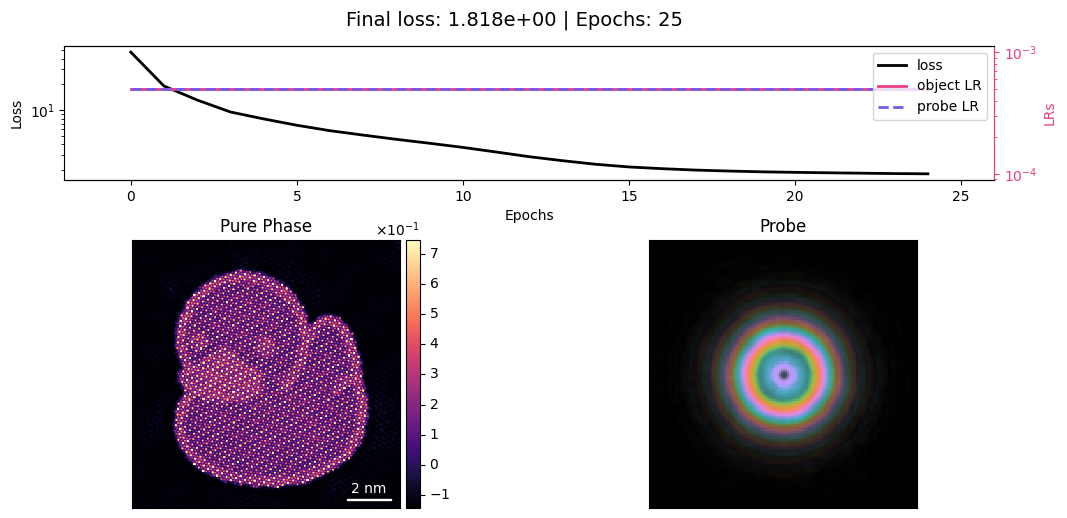

In [ ]:
opt_params = {  
    "object": {
        "type": "adam",  
        "lr": 5e-4,
    },
    "probe": {
        "type": "adam",
        "lr": 5e-4,
    },
}

scheduler_params = {
    "object": {
        "type": "plateau",
        # "patience": 20,
        # "factor": 0.25,
        # "cooldown": 20,
    },
    "probe": {
        "type": "plateau",
        # "factor": 0.25,
    },
}
constraints = {
}

# ptycho.remove_optimizer("probe")
ptycho_dip.reconstruct(
    num_iter=25,
    reset=True,
    # obj_type="complex",
    optimizer_params=opt_params,
    scheduler_params=scheduler_params,
    constraints=constraints,
    batch_size=128,
    # loss_type="l2",
).visualize()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100, Loss: 1.539e+00: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


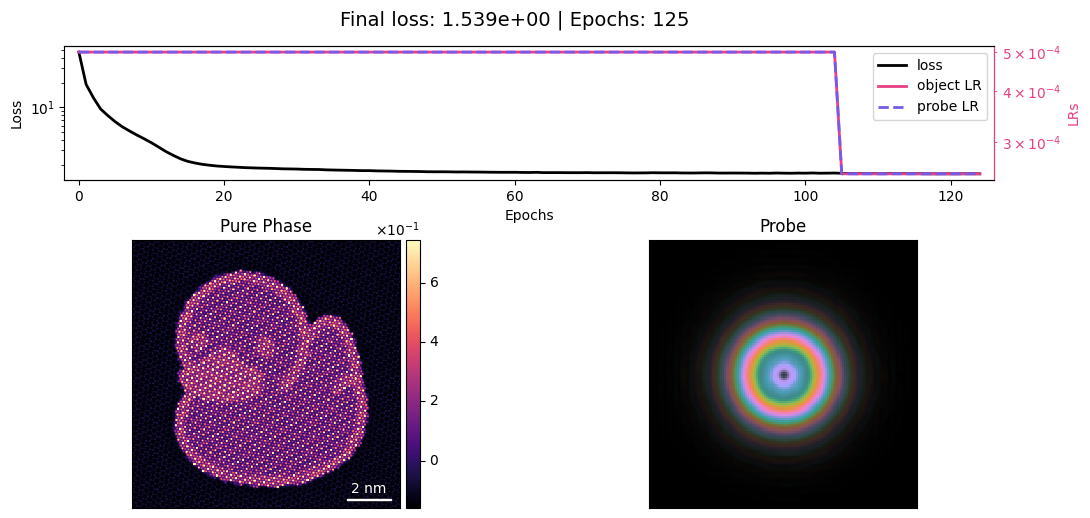

In [ ]:
ptycho_dip.reconstruct(
    num_iter=100,
).visualize()

In [ ]:
# show_2d(
#     [ptycho_dip.obj_cropped[0], ptycho_dip.obj_cropped[0, :80, :80]],
#     cmap=["turbo", "magma"],
#     title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs | noise_std {obj_model_dip._input_noise_std}", f"DIP {ptycho_dip.num_epochs} epochs zoom"]
# )
# show_2d(
#     [
#        ptycho_dip.obj_cropped[0],
#        ptycho_dip.obj_cropped[0, :80, :80],
#        ptycho_dip.obj_cropped[0, 100:180, 100:180],
#     ],
#     cmap="magma",
#     title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs | noise_std {obj_model_dip._input_noise_std}", "DIP zoom", "DIP zoom"],
# )

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'DIP pure_phase | 125 epochs | noise_std 0.025'}>,
        <Axes: title={'center': 'DIP zoom'}>,
        <Axes: title={'center': 'DIP zoom'}>], dtype=object))

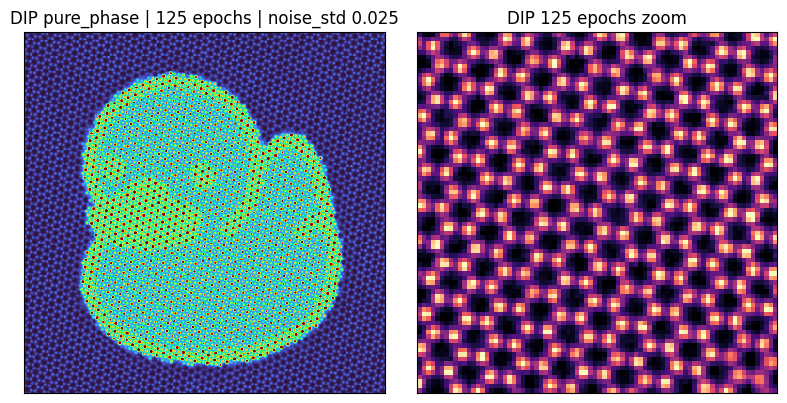

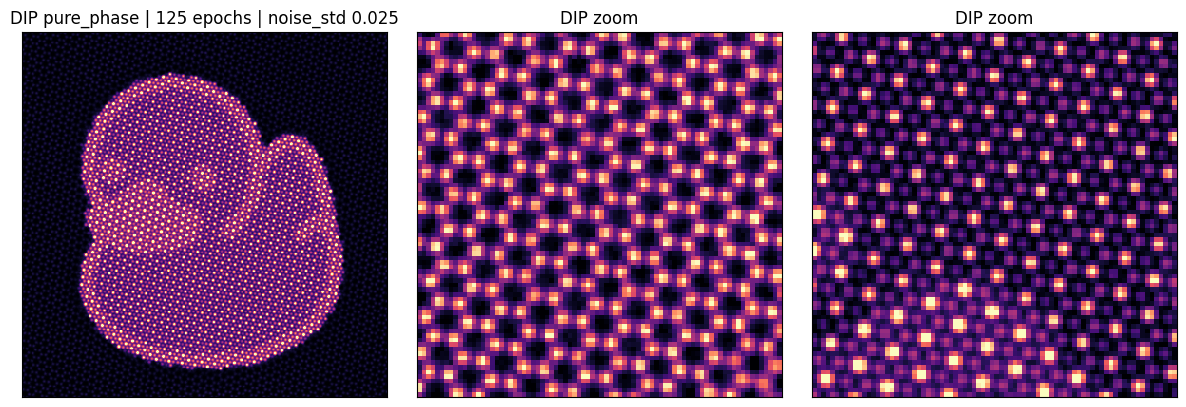

In [ ]:
show_2d(
    [np.angle(ptycho_dip.obj_cropped[0]), np.angle(ptycho_dip.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs | noise_std {obj_model_dip._input_noise_std}", f"DIP {ptycho_dip.num_epochs} epochs zoom"]
)
show_2d(
    [
        np.angle(ptycho_dip.obj_cropped[0]),
        np.angle(ptycho_dip.obj_cropped[0, :80, :80]),
        np.angle(ptycho_dip.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=[f"DIP {ptycho_dip.obj_model.obj_type} | {ptycho_dip.num_epochs} epochs | noise_std {obj_model_dip._input_noise_std}", "DIP zoom", "DIP zoom"],
)